In [1]:
import pandas as pd 
import os
import numpy as np
from matplotlib import pyplot as plt
from rasterio.mask import raster_geometry_mask, mask
import cv2
from FDD import FDD
from FDD.SURE import SURE

def moveUp(fn, times = 1):
    for _ in range(times):
        fn = os.path.dirname(fn)
    return fn

# dir = os.path.dirname(os.path.realpath(__file__))
# os.chdir(dir)

# get directory above
main_dir = "/home/dvdijcke/" # moveUp(dir, 4)
data_in = os.path.join(main_dir, 'data', 'in')    
data_out = os.path.join(main_dir, 'data', 'out')  

In [8]:

#------------------------
## boe lifted image

boe = cv2.imread(os.path.join(data_in, 'boe.jpeg'), cv2.IMREAD_GRAYSCALE)
# resize
boe = cv2.resize(boe, (0,0), fx=0.25, fy=0.25)

Y = boe.flatten()
X = np.stack(np.meshgrid(*[np.arange(boe.shape[1]), np.arange(boe.shape[0])]), axis = -1)
X = X.reshape(-1, 2)

resolution = 1/int(np.sqrt(Y.size*0.25))
model = FDD(Y, X, level = 16, lmbda = 50, nu = 0.003, iter = 10000, tol = 5e-5, resolution=resolution,
    pick_nu = "MS", scaled = True, scripted = False, rectangle=True)



In [9]:
# modify function to return lifted image as well
from types import MethodType

def run(self):

    f, repeats, level, lmbda, nu, tol = \
        self.arraysToTensors(self.grid_y, self.iter, self.level, self.lmbda, self.nu, self.tol)

    if self.scripted:
        results = self.model(f, repeats, level, lmbda, nu, tol)
    else:
        results = self.model.forward(f, repeats, level, lmbda, nu, tol)

    v, nrj, eps, it = results

    u, jumps, J_grid, nrj, eps, it = self.processResults(results)

    return (u, jumps, J_grid, nrj, eps, it, v)

model.run = MethodType(run, model)


In [10]:
u, jumps, J_grid, nrj, eps, it, v = model.run()


In [42]:
def isosurface_lifted(u, grid_y):

    mask = (u[...,:-1] > 0.5) & (u[...,1:] <= 0.5)
    # Find the indices of the first True value along the last dimension, and set all the following ones to False
    mask[..., 1:] = (mask[..., 1:]) & (mask.cumsum(-1)[...,:-1] < 1)

    uk0 = u[...,:-1][mask]
    uk1 = u[...,1:][mask]

    # get the indices of the last dimension where mask is True
    k = np.where(mask == True)[-1] + 1

    #h_img = self.interpolate(k, uk0, uk1, self.level).reshape(self.grid_y.shape[:-1])

    return k.reshape(grid_y.shape[:-1])

test = isosurface_lifted(v.cpu().detach().numpy(), model.grid_y)
test = test / test.max()

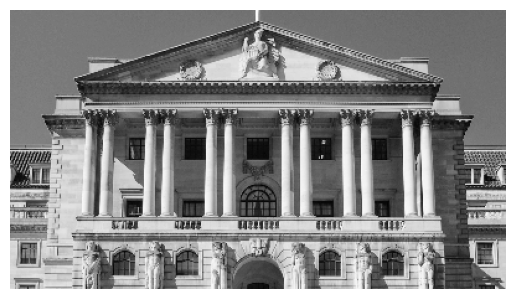

In [29]:
plt.imshow(boe, cmap='gray')
plt.axis("off")
plt.savefig("boe_input.png", bbox_inches="tight")

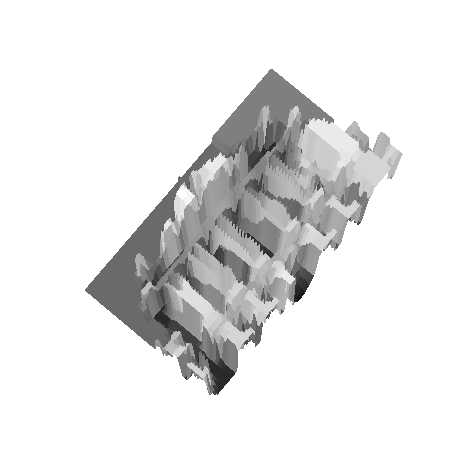

In [52]:
# Create a new figure
fig = plt.figure()

# Add 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Plot surface
ax.plot_surface(model.grid_x[...,1], model.grid_x[...,0], test, cmap="gray", linewidth=0, antialiased=False, alpha=None)

# Set the view angle
ax.view_init(elev=80, azim=40)

# "Zoom out" by setting larger limits on the axes
x_range = model.grid_x[...,1].ptp()
y_range = model.grid_x[...,0].ptp()
z_range = test.ptp()

# ax.set_xlim(model.grid_x[...,1].min() - 0.1 * x_range, model.grid_x[...,1].max() + 0.1 * x_range)
# ax.set_ylim(model.grid_x[...,0].min() - 0.1 * y_range, model.grid_x[...,0].max() + 0.1 * y_range)
# ax.set_zlim(test.min() - 0.1 * z_range, test.max() + 0.1 * z_range)

#ax.axis("off")
# Display the plot
ax.axis("scaled")
ax.axis("off")
#plt.show()
plt.tight_layout()
plt.savefig("boe_lifted.png", bbox_inches="tight")

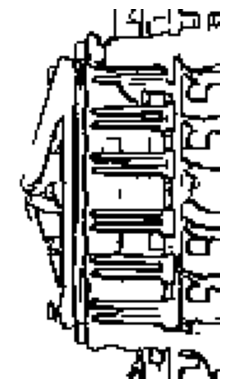

In [31]:
plt.imshow(J_grid, cmap="binary")
plt.axis("off")
plt.savefig("boe_Jgrid.png", bbox_inches="tight")

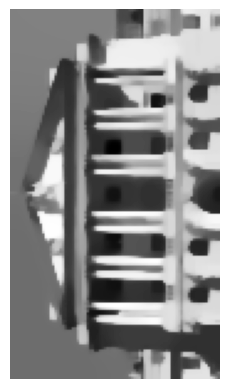

In [32]:
plt.imshow(u, cmap="gray")
plt.axis("off")
plt.savefig("boe_u.png", bbox_inches="tight")